<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/VisionTransformer_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import BCELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import matplotlib.pyplot as plt

import random
import cv2
import copy
import bisect

np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

In [ ]:
model_name = 'VisionTransformer_MNIST_AE_256.pth'
state_dict_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f'Using device {device}'

'Using device cpu'

# Prepare data

In [ ]:
mnist_train = MNIST(root='./mnist', train=True, download=True, transform=ToTensor()) 
mnist_test = MNIST(root='./mnist', train=False, download=True, transform=ToTensor()) 

In [ ]:
class ae_mnist(Dataset):
  def __init__(self, xy_mnist):
    self.dset = [(xy[0], xy[0]) for xy in xy_mnist]

  def __getitem__(self, idx):
    return self.dset[idx]

  def __len__(self):
    return len(self.dset)

  def show(self, idx):
    f, axs = plt.subplots(1,2)
    tup = self.dset[idx]
    for i in range(len(tup)):
      im_cv = tup[i].numpy().transpose(1,2,0).squeeze()
      im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
      axs[i].title.set_text('Input' if i==0 else 'Target')
      axs[i].imshow(im_rgb)
    plt.imshow(im_rgb)

In [ ]:
train_dset = ae_mnist(mnist_train)
test_dset = ae_mnist(mnist_test)

In [ ]:
train_dl = DataLoader(train_dset, shuffle=True, batch_size=128)
test_dl = DataLoader(test_dset, shuffle=False, batch_size=128)

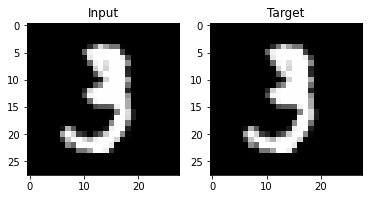

In [ ]:
train_dl.dataset.show(10)

# Create VisionTransformer & Convolutional AE model class

### Helper functions

In [ ]:
"""
We reshape our input from shape (N, C=1, H=28, W=28) to shape (N, #Patches, Patch dimensionality).
We will divide our input image to 7x7=49 separate patches of size 1x4x4=16 giving us the new shape (N, 49, 16)
"""
def patchify(images, n_patches):
  n, c, h, w = images.shape

  assert h == w, "Patchify function only works for square images"
    
  patch_size = h // n_patches
  return torch.stack([torch.stack([image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size][0].flatten() for i in range(n_patches) for j in range(n_patches)]) for image in images])
  

In [ ]:
"""
Allows the model to understand where each patch would be placed in the original image. In each sequence,
for token i, we add its j-th coordinate 
"""
def get_positional_embeddings(sequence_length, dim):
  res = torch.ones(sequence_length, dim)
  for i in range(sequence_length):
    for j in range(dim):
      res[i][j] = np.sin(i / (10_000 ** (j/dim))) if j % 2 == 0 else np.cos(i / (10_000 ** ((j-1) / dim )))
  return res

# plt.imshow(get_positional_embeddings(50, 100), cmap='hot')

In [ ]:
"Multi-head Self Attention"
class MSA(nn.Module):
  def __init__(self, dim, n_heads=2):
    super(MSA, self).__init__()
    self.dim, self.n_heads = dim, n_heads

    assert dim % n_heads == 0, f'Can not evenly divide {dim} by {n_heads}'

    head_dim = int(dim / n_heads); 
    self.q_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.k_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.v_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.head_dim = head_dim
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, sequences):
    """
    We have input shape (N, Seq_len, Token_dim) 
    We go to shape (N, Seq_len, n_heads, head_dim) where head_dim = Token_dim / n_heads
    Then we end at shape (N, Seq_len, Item_dim) through concatenation
    """
    res = []
    for sequence in sequences:
      seq_res = []
      for head in range(self.n_heads):
        q_mapping = self.q_mappings[head]
        k_mapping = self.q_mappings[head]
        v_mapping = self.q_mappings[head]

        seq = sequence[:, head * self.head_dim: (head + 1) * self.head_dim]
        q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

        attention = self.softmax(q @ k.T / (self.head_dim ** 0.5))
        seq_res.append(attention @ v)
    
      res.append(torch.hstack(seq_res))
    return torch.cat([torch.unsqueeze(r, dim=0) for r in res])


# Test output
out = MSA(8)(torch.randn(7,50,8))
out.shape

torch.Size([7, 50, 8])

In [ ]:
class VisionTransformer_block(nn.Module):
  def __init__(self, hidden_dim, n_heads=2, mlp_ratio=4):
    super(VisionTransformer_block, self).__init__()

    self.hidden_dim, self.n_heads = hidden_dim, n_heads

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.msa = MSA(hidden_dim, n_heads)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim * mlp_ratio),
        nn.GELU(),
        nn.Linear(hidden_dim * mlp_ratio, hidden_dim)
    )

  def forward(self, x):
    out = x + self.msa(self.norm1(x))
    out = out + self.mlp(self.norm2(out))
    return out


# Test output
out = VisionTransformer_block(8)(torch.randn(7,50,8))
out.shape

torch.Size([7, 50, 8])

## Encoder class

In [ ]:
class VisionTransformer_encoder(nn.Module):
  def __init__(self, chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=256):
    super(VisionTransformer_encoder, self).__init__()
    
    self.chw, self.n_patches, self.n_blocks, self.hidden_dim, self.n_heads = chw, n_patches, n_blocks, hidden_dim, n_heads

    # Input & Patches sizes
    assert chw[1] % n_patches == 0, "Input shape is not entirely diversible by the number of patches!"
    assert chw[2] % n_patches == 0, "Input shape is not entirely diversible by the number of patches!"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)

    # 2) Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_dim))

    # 3) Positional embedding
    self.pos_embed = nn.Parameter((get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_dim)).clone().detach())
    self.pos_embed.requires_grad = False

    # 4) Transformer encoder
    self.blocks = nn.ModuleList([VisionTransformer_block(hidden_dim, n_heads) for _ in range(n_blocks)])

    # 5) Latent feature output INSTEAD OF Classification MLPk
    self.latent_feature = nn.Sequential(
        nn.Linear((self.n_patches ** 2 + 1) * self.hidden_dim, 128),
        nn.ReLU(),
        nn.Linear(128, out_dim)
        )

  def forward(self, images):
    "Divide images into patches"
    "(N, C, H, W) -> (N, n_Patches, d_Patch)"
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches)


    "Running linear layer tokenization. Maps the vector corresponding to each patch to the hidden dimension"
    "(N, n_Patches, d_Patch) -> (N, n_Patches, Token_dim) - Token_dim = hidden_dim"
    tokens = self.linear_mapper(patches)

    "Adding classification token to the tokens"
    "(N, n_Patches, Token_dim) -> (N, Seq_len, Token_dim) - Seq_len = n_Patches + 1"
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    "Adding positional embedding to the tokens"
    "(N, Seq_len, Token_dim)"
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed

    "Transformer blocks"
    for block in self.blocks:
      out = block(out)

    out = out.view(n, 1, (self.n_patches ** 2 + 1) * self.hidden_dim)
    out = self.latent_feature(out).squeeze()

    return out


# Shape of output
out = VisionTransformer_encoder()(torch.randn(7,1,28,28))
out.shape

torch.Size([7, 256])

## Decoder class(es)

### 256

In [ ]:
class VisionTransformer_decoder(nn.Module):
  def __init__(self, input_dim=256):
    super(VisionTransformer_decoder, self).__init__()

    assert input_dim ** 0.5 % 2 == 0, 'Bad input dimension, sqrt(input_dim) must be an even number'

    self.input_dim = input_dim

    self.cnnt1 = nn.Sequential(     
      nn.ConvTranspose2d(1, input_dim, 4, stride=1),
      nn.ReLU(),

      nn.ConvTranspose2d(input_dim, 128, 4, stride=1),
      nn.ReLU(),

      nn.ConvTranspose2d(128, 64, 4, stride=1),
      nn.ReLU(),

      nn.ConvTranspose2d(64, 1, 4, stride=1),
      nn.Sigmoid()
    )
    
  def forward(self, latent_vector):
    assert latent_vector.shape[-1] == self.input_dim, "Dimension of vector does not match the initialized input dimension"

    n, d = latent_vector.shape
    x = latent_vector.view(n, 1, int(d ** 0.5), int(d ** 0.5))
    out = self.cnnt1(x)
    return out

# Test output shape
out = VisionTransformer_decoder()(torch.rand(7, 256))
out.shape

torch.Size([7, 1, 28, 28])

## AE class

In [ ]:
class VisionTransformer_Conv_AE(nn.Module):
  def __init__(self, encoder, decoder):
    super(VisionTransformer_Conv_AE, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, images):
    encoded_input = self.encoder(images)
    decoded_output = self.decoder(encoded_input)
    return decoded_output

# Train model

## Instatiate model & Environment settings

In [ ]:
encoder_weights_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/VisionTransformer_MNIST_Classifier.pth'

# Encoder
encoder = VisionTransformer_encoder(chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=256).to(device)
encoder.load_state_dict(torch.load(encoder_weights_path, map_location=torch.device(device)), strict=False)

# Decoder
decoder = VisionTransformer_decoder(input_dim=256).to(device)

# AutoEncoder
model = VisionTransformer_Conv_AE(encoder, decoder).to(device)

In [ ]:
lr = 5e-3
epochs = 10
optim = Adam(model.parameters(), lr=lr)
criterion = BCELoss()

In [ ]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in trainable_params])

### Training loop

In [ ]:
print(f'{"-"*20}Training model {model_name} for {epochs} epochs with {trainable_params} trainable params and learning rate of {lr}{"-"*20}\n')
min_test_loss = np.inf
for epoch in range(epochs):
  train_epoch_loss = 0.
  model.train()
  for batch in tqdm(train_dl, desc=f'Training Epoch: [{epoch + 1} ---> {epochs}]', position=0, leave=True):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)

    train_loss = criterion(y_hat, y)
    train_epoch_loss += train_loss.detach().cpu().item() / len(train_dl)

    optim.zero_grad()
    train_loss.backward()
    optim.step()

  with torch.no_grad():
    test_epoch_loss = 0
    model.eval()
    for batch in tqdm(test_dl, desc=f'Testing Epoch [{epoch + 1} ---> {epochs}]', position=0, leave=True):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)

      test_loss = criterion(y_hat, y)
      test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

    print(f'[Epoch {epoch + 1}]\tTrain loss: {train_epoch_loss:.4f}\tTest loss {test_epoch_loss:.4f}')

    if test_epoch_loss < min_test_loss:
      print(f'Test loss decreased ({min_test_loss:.4f}--->{test_epoch_loss:.4f})\tSaving the model...\n')
      min_test_loss = test_epoch_loss
      torch.save(model.state_dict(), save_path)
    else: print('')

--------------------Training model VisionTransformer_MNIST_AE_64.pth for 10 epochs with 359953 trainable params and learning rate of 0.005--------------------



Testing Epoch [1 ---> 10]: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s]


[Epoch 1]	Train loss: 0.3202	Test loss 0.2778
Test loss decreased (inf--->0.2778)	Saving the model...



Testing Epoch [2 ---> 10]: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


[Epoch 2]	Train loss: 0.2734	Test loss 0.2696
Test loss decreased (0.2778--->0.2696)	Saving the model...



Testing Epoch [3 ---> 10]: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


[Epoch 3]	Train loss: 0.2681	Test loss 0.2676
Test loss decreased (0.2696--->0.2676)	Saving the model...



Testing Epoch [4 ---> 10]: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


[Epoch 4]	Train loss: 0.2668	Test loss 0.2656
Test loss decreased (0.2676--->0.2656)	Saving the model...



Testing Epoch [5 ---> 10]: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


[Epoch 5]	Train loss: 0.2658	Test loss 0.2653
Test loss decreased (0.2656--->0.2653)	Saving the model...



Testing Epoch [6 ---> 10]: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


[Epoch 6]	Train loss: 0.2655	Test loss 0.2658



Testing Epoch [7 ---> 10]: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


[Epoch 7]	Train loss: 0.2653	Test loss 0.2649
Test loss decreased (0.2653--->0.2649)	Saving the model...



Training Epoch: [8 ---> 10]:  15%|█▌        | 71/469 [00:33<03:10,  2.09it/s]


KeyboardInterrupt: ignored

# Test model

## Instantiate model & load trained weights

In [ ]:
# Encoder
encoder = VisionTransformer_encoder(chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=256).to(device)

# Decoder
decoder = VisionTransformer_decoder(input_dim=256)

# AutoEncoder
model = VisionTransformer_Conv_AE(encoder, decoder).to(device)
model.load_state_dict(torch.load(state_dict_path, map_location=torch.device(device)))

<All keys matched successfully>

## Test performance

In [ ]:
criterion = BCELoss()

In [ ]:
print(f'{"-"*20}Testing model {model_name}{"-"*20}\n')

with torch.no_grad():
  test_epoch_loss = 0
  model.eval()
  for batch in tqdm(test_dl, desc=f'Testing', position=0, leave=True):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)

    test_loss = criterion(y_hat, y)
    test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

  print(f' ---> Test loss: {test_epoch_loss:.4f}')

--------------------Testing model VisionTransformer_MNIST_AE_256.pth--------------------



Testing: 100%|██████████| 79/79 [02:28<00:00,  1.88s/it]

 ---> Test loss: 0.0781


## Perform inference

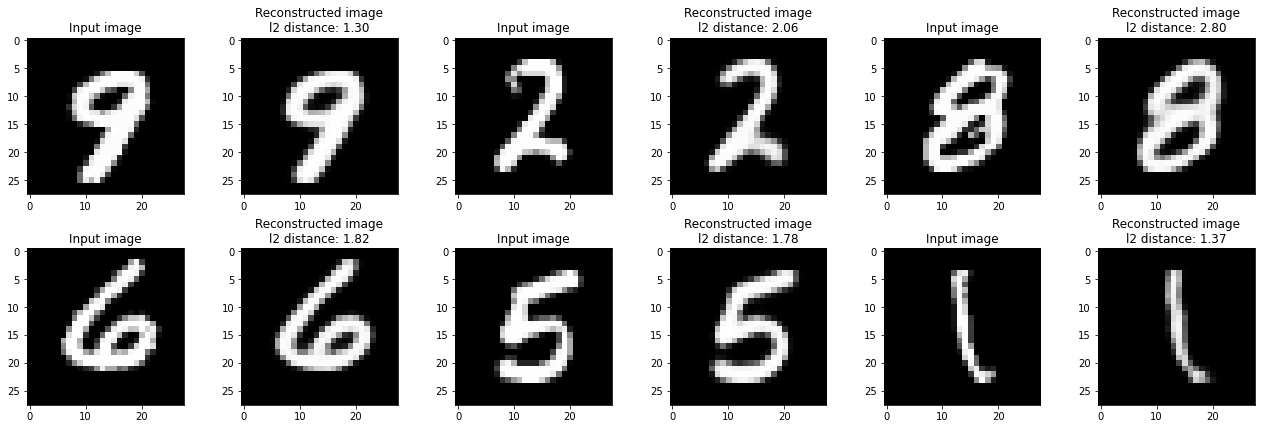

In [ ]:
def show_preds(real_images=True, n_preds=6, n_cols=6):
  assert n_cols % 2 == 0, 'n_cols must be an even int'

  n_rows = bisect.bisect_right([i for i in range(n_preds*2) if i % n_cols == 0], n_preds*2)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
  axs = axs.flatten()

  with torch.no_grad():
    if real_images: 
      ims = tuple([random.choice(test_dl.dataset)[0] for _ in range(n_preds)])
      inputs = torch.stack(ims)
      preds = model(inputs.to(device))
    else: 
      inputs = torch.rand(n_preds,1,28,28)
      preds = model(inputs.to(device))

    imgs = [item for pair in zip(inputs, preds) for item in pair]
    
    for idx in range(n_preds*2):
      im = imgs[idx]
      im_cv = im.cpu().numpy().transpose(1,2,0).squeeze()
      im_rgb = cv2.cvtColor(im_cv*255, cv2.COLOR_BGR2RGB).astype(np.uint8)
      axs[idx].title.set_text('Input image' if idx % 2 ==0 else f'Reconstructed image\nl2 distance: {torch.dist(imgs[idx-1],imgs[idx],2):.2f}')
      axs[idx].imshow(im_rgb)

  plt.tight_layout()
  plt.show()

show_preds()

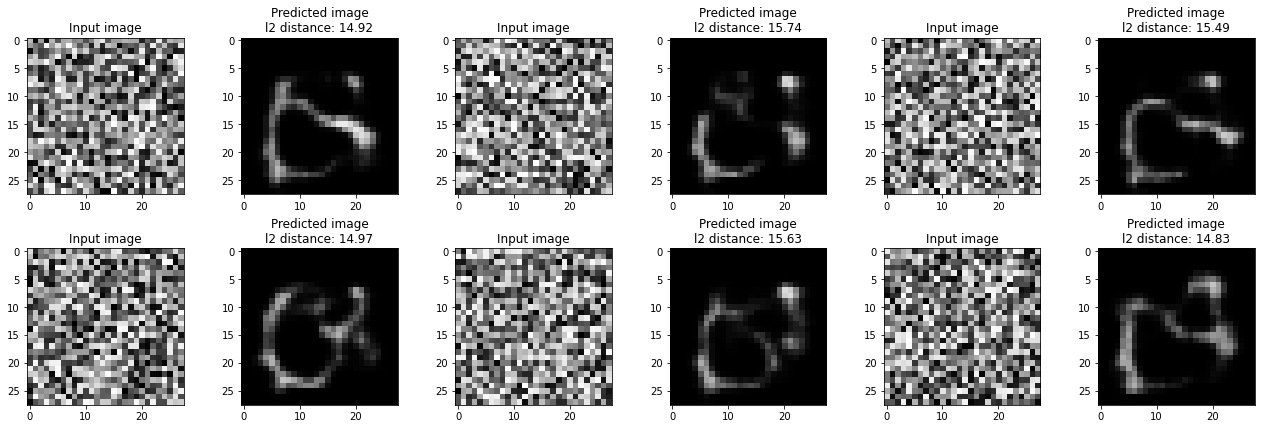

In [ ]:
show_preds(real_images=False)